# 3.7 "찐" Multi-Agent System (feat. create_react_agent)

In [1]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

True

In [2]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

# llm = ChatOpenAI(model="gpt-4o-mini")
llm = ChatOllama(model="llama3.1")

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


```python
"supervisor"
"market_research", "stock_research", "company_research"
"analyst"
```

In [3]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_community.tools import YahooFinanceNewsTool, PolygonTickerNews
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage

def market_research(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    시장 조사 node입니다. 주어진 state를 기반으로 시장 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.
    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    print("**** market_research ****")
    market_research_tools = [
        YahooFinanceNewsTool(),
        PolygonTickerNews(api_wrapper=PolygonAPIWrapper()),
    ]
    market_research_agent = create_agent(
        model=llm,
        tools=market_research_tools,
        system_prompt="너는 시장 조사 전문가야. 의견 빼고 사실만 제공해 줘",
    )
    result = market_research_agent.invoke(state)
    return Command(
        goto="supervisor",
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="market_research")]},
    )

In [4]:
from langchain_core.tools import tool
import yfinance as yf

@tool
def get_stock_price(ticker: str) -> dict:
    """개별 종목에 대한 지난 1달 주가 데이터를 반환합니다."""
    return yf.download(tickers=ticker, period="1mo").to_dict()


def stock_research(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    주식 조사 node입니다. 주어진 State를 기반으로 주식 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.
    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    print("**** stock_research ****")
    stock_research_tools = [get_stock_price]
    stock_research_agent = create_agent(
        model=llm,
        tools=stock_research_tools,
        system_prompt="너는 주식 조사 전문가야. 의견 빼고 사실만 제공해 줘",
    )
    result = stock_research_agent.invoke(state)
    return Command(
        goto="supervisor",
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="stock_research")]}
    )

In [5]:
@tool
def get_company_infos(ticker: str) -> dict:
    """개별 종목에 대한 재무 정보와 공시 자료를 반환합니다."""
    company_info = yf.Ticker(ticker=ticker)
    financial_info = company_info.get_financials()
    sec_filings = company_info.get_sec_filings()
    return {
        "financial_info": financial_info,
        "sec_filings": sec_filings
    }


def company_research(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    회사 조사 node입니다. 주어진 State를 기반으로 회사 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.
    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    print("**** company_research ****")
    company_research_tools = [get_company_infos]
    company_research_agent = create_agent(
        model=llm,
        tools=company_research_tools,
        system_prompt="너는 기업 조사 전문가야. 의견 빼고 사실만 제공해 줘",
    )
    result = company_research_agent.invoke(state)
    return Command(
        goto="supervisor",
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="company_research")]},
    )

In [6]:
from langchain_core.prompts import PromptTemplate

def analyst(state: MessagesState) -> MessagesState:
    """
    분석가 node입니다. 주어진 State를 기반으로 분석가 체인을 호출하고,
    결과 메시지를 반환합니다.
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.
    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환합니다.
    """
    print("**** analyst ****")
    analyst_prompt = PromptTemplate.from_template(
        """너는 주식 시장 전문가야. 아래 정보를 참고해서 살지, 팔지, 보유할지 알려줘
        information: {messages}""")
    analyst_chain = analyst_prompt | llm
    result = analyst_chain.invoke({"messages": state["messages"][1:]})
    return {"messages": [result]}

In [7]:
from typing import TypedDict

members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.")


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH"""
    next: Literal[*options]


def supervisor(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node입니다. 주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정합니다. 모든 작업이 완료되면 analyst node로 이동합니다.
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.
    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령을 반환합니다.
    """
    print("**** supervisor ****")
    messages = [{
        "role": "system",
        "content": system_prompt,
    }] + state["messages"]
    response = llm.with_structured_output(schema=Router).invoke(messages)
    goto = response["next"]
    if goto == "FISISH":
        goto = "analyst"
    return Command(goto=goto)

In [8]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(state_schema=MessagesState)

workflow.add_node(supervisor)
workflow.add_node(market_research)
workflow.add_node(stock_research)
workflow.add_node(company_research)
workflow.add_node(analyst)

workflow.add_edge(START, "supervisor")
workflow.add_edge("analyst", END)

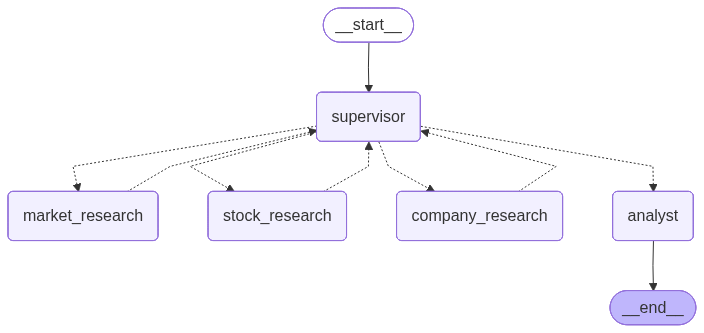

In [9]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
query = "엔비디아(NVDA)에 지금 투자하는게 좋을까?"

for response in graph.stream({"messages": [("user", query)]}, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

엔비디아(NVDA)에 지금 투자하는게 좋을까?
**** supervisor ****
**** market_research ****
================================ Human Message =================================
Name: market_research

The input appears to be a JSON list of articles with their respective sentiment analysis on various stocks related to artificial intelligence (AI). 

Here are the insights extracted from each article:

1. **Article 1: "This ETF Offers Exposure to the AI Boom" by Benzinga**
   - Sentiment for NVDA: Positive

2. **Article 2: "Prediction: This Artificial Intelligence (AI) Stock Could 5X by 2030" by The Motley Fool**
   - Sentiment for AMD: Positive
   - Sentiment for NVDA: Neutral

3. **Article 3: "All-In On AI: What Happens If the Bubble Pops In 2026?" by Benzinga**
   - Sentiment for SPY: Negative
   - Sentiment for MSFT: Negative
   - Sentiment for GOOG: Negative
   - Sentiment for GOOGL: Negative
   - Sentiment for META: Negative


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT